In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
# Path to CSV file
csv_path = "/content/drive/My Drive/speech_ml/data/labeled_transcripts.csv"
save_path = "/content/drive/My Drive/speech_ml/data/"
df = pd.read_csv(csv_path)

df = df.sort_values(by=["Speech_ID", "Chunk_ID"]).reset_index(drop=True)
print(df.head())


   Speech_ID     VideoTitle Chunk_ID  \
0          1  Muniba_Mazari      1_0   
1          1  Muniba_Mazari      1_1   
2          1  Muniba_Mazari     1_10   
3          1  Muniba_Mazari     1_11   
4          1  Muniba_Mazari     1_12   

                                               Chunk  completed_percentage  \
0  Whoa. I'm running short of words right now, bu...                  0.00   
1  Well, I always start my talk with a disclaimer...                  1.89   
2  But that injury that changed me and my life co...                 18.87   
3  Many people came to rescue. They gave me CPR. ...                 20.75   
4  She's going to die. Where should we go? There ...                 22.64   

  completion_range_percentage  
0                         0-5  
1                         0-5  
2                       15-20  
3                       20-25  
4                       20-25  


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer

In [ ]:

# Load chunked dataset
df = pd.read_csv('/content/drive/My Drive/speech_ml/data/labeled_transcripts.csv')

# Encode using SentenceTransformer
model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(df['Chunk'].tolist(), show_progress_bar=True)

# Save
df['embedding'] = embeddings.tolist()
np.save('/content/drive/My Drive/speech_ml/data/chunk_embeddings.npy', embeddings)
df.to_pickle('/content/drive/My Drive/speech_ml/data/df_with_embeddings.pkl')
print("Embeddings saved")


In [ ]:
# Paths
save_path = "/content/drive/My Drive/speech_ml/data/"
df_path = os.path.join(save_path, "df_with_embeddings.pkl")
embedding_path = os.path.join(save_path, "chunk_embeddings.npy")

# Load data
df = pd.read_pickle(df_path)
embeddings = np.load(embedding_path)


In [ ]:
print(df.head())

   Speech_ID     VideoTitle Chunk_ID  \
0          1  Muniba_Mazari      1_0   
1          1  Muniba_Mazari      1_1   
2          1  Muniba_Mazari      1_2   
3          1  Muniba_Mazari      1_3   
4          1  Muniba_Mazari      1_4   

                                               Chunk  completed_percentage  \
0  Whoa. I'm running short of words right now, bu...                  0.00   
1  Well, I always start my talk with a disclaimer...                  1.89   
2  Because when you think that way, you are being...                  3.77   
3  They can damage you forever. So I always try t...                  5.66   
4  I call it strength. They call me disabled. I c...                  7.55   

  completion_range_percentage  \
0                         0-5   
1                         0-5   
2                         0-5   
3                        5-10   
4                        5-10   

                                           embedding  
0  [0.01609218865633011, 0.008985621

In [ ]:
def compute_structural_features(text):
    import re
    words = text.split()
    num_words = len(words)
    num_chars = len(text)
    num_commas = text.count(',')
    num_periods = text.count('.')
    num_exclaims = text.count('!')
    num_questions = text.count('?')
    unique_words = len(set(words))
    fraction_unique_words = unique_words / (num_words + 1e-5)

    return pd.Series({
        'num_words': num_words,
        'num_chars': num_chars,
        'num_commas': num_commas,
        'num_periods': num_periods,
        'num_exclaims': num_exclaims,
        'num_questions': num_questions,
        'unique_words': unique_words,
        'fraction_unique_words': fraction_unique_words
    })

structural_df = df['Chunk'].apply(compute_structural_features)
df = pd.concat([df, structural_df], axis=1)


In [ ]:
pca = PCA(n_components=5, random_state=42)
pca_features = pca.fit_transform(embeddings)

for i in range(5):
    df[f'pca_{i+1}'] = pca_features[:, i]


In [ ]:
import umap
import hdbscan

# === UMAP ===
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.0, n_components=2, random_state=42)
umap_embeds = umap_model.fit_transform(embeddings)

# === HDBSCAN ===
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, prediction_data=True)
cluster_labels = clusterer.fit_predict(umap_embeds)

# Save cluster labels to DataFrame
df['cluster'] = cluster_labels
df['is_noise'] = (df['cluster'] == -1).astype(int)


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
joblib.dump(umap_model, '/content/drive/My Drive/speech_ml/data/umap_model.pkl')


['/content/drive/My Drive/speech_ml/umap_model.pkl']

In [ ]:
# Compute cluster_seen_before and fraction_unique_clusters
cluster_progress = []
fraction_unique_clusters = []

for _, group in df.groupby("Speech_ID"):
    seen = set()
    total_clusters = set(group['cluster'].unique())
    cluster_seen = []
    frac_unique = []

    for c in group['cluster']:
        cluster_seen.append(int(c in seen))
        seen.add(c)
        frac_unique.append(len(seen) / len(total_clusters))

    cluster_progress.extend(cluster_seen)
    fraction_unique_clusters.extend(frac_unique)

df['cluster_seen_before'] = cluster_progress
df['fraction_unique_clusters'] = fraction_unique_clusters


In [ ]:
from sklearn.model_selection import train_test_split

FEATURES = [
    'num_words', 'num_chars', 'num_commas', 'num_periods', 'num_exclaims', 'num_questions',
    'unique_words', 'fraction_unique_words',
    'cluster', 'is_noise', 'cluster_seen_before', 'fraction_unique_clusters',
    'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5'
]

X = df[FEATURES]
y = df['completed_percentage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from lightgbm import early_stopping, log_evaluation
import lightgbm as lgb

model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='mae',
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(50)]
)


y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Trained")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 1951, number of used features: 17
[LightGBM] [Info] Start training from score 47.384736
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l1: 17.9846	valid_0's l2: 440.608
[100]	valid_0's l1: 14.569	valid_0's l2: 301.507
[150]	valid_0's l1: 12.8596	valid_0's l2: 248.475
[200]	valid_0's l1: 11.9573	valid_0's l2: 228.405
[250]	valid_0's l1: 11.4969	valid_0's l2: 221.143
[300]	valid_0's l1: 11.2591	valid_0's l2: 217.754
[350]	valid_0's l1: 11.1102	valid_0's l2: 215.711
[400]	valid_0's l1: 11.0309	valid_0's l2: 214.91
Early stopping, best iteration is:
[383]	valid_0's l1: 11.036	valid_0's l2: 214.595
Model Trained
MAE: 11.04
R² Score: 0.73


/tmp/ipython-input-27-1726732104.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')


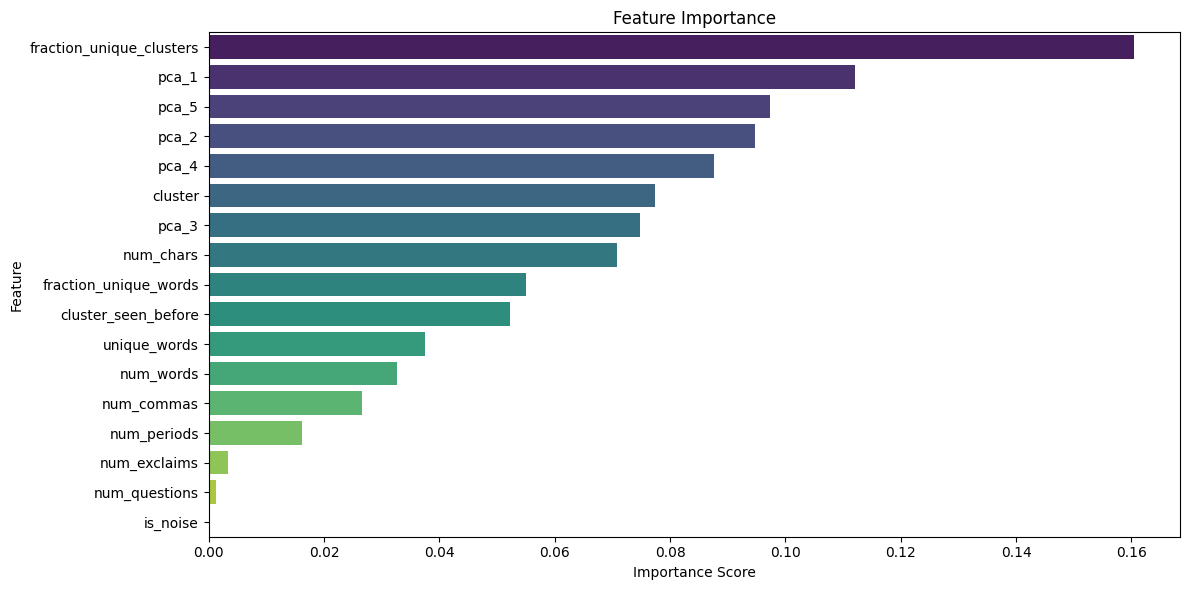

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = pd.DataFrame({
    'feature': FEATURES,
    'importance': model.feature_importances_ / model.feature_importances_.sum()
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


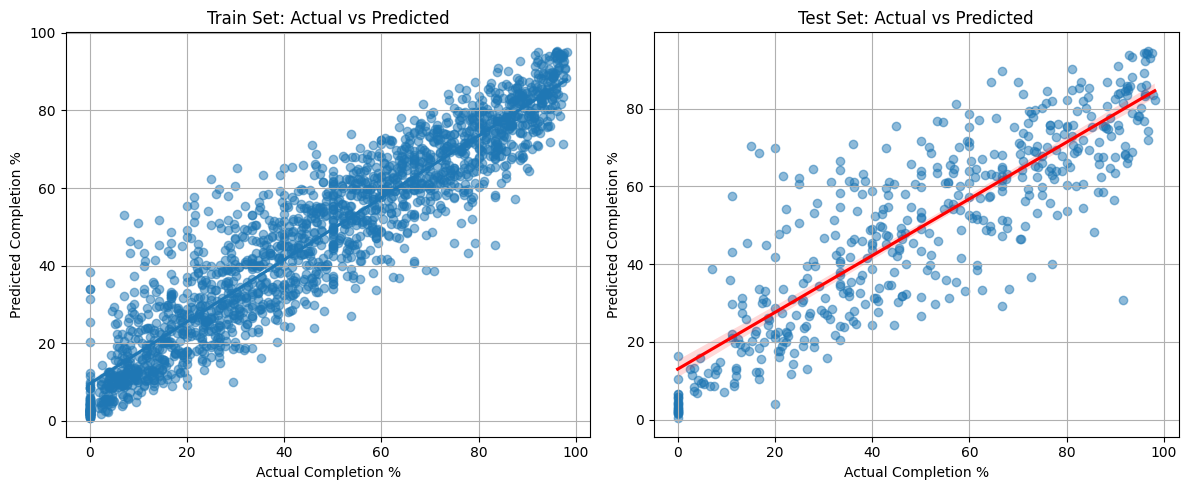

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict on both train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Plot: Actual vs Predicted for TRAIN
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.regplot(x=y_train, y=y_train_pred, scatter_kws={'alpha':0.5})
plt.title("Train Set: Actual vs Predicted")
plt.xlabel("Actual Completion %")
plt.ylabel("Predicted Completion %")
plt.grid(True)

# Plot: Actual vs Predicted for TEST
plt.subplot(1, 2, 2)
sns.regplot(x=y_test, y=y_test_pred, scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
plt.title("Test Set: Actual vs Predicted")
plt.xlabel("Actual Completion %")
plt.ylabel("Predicted Completion %")
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import joblib

# Save model
joblib.dump(model, '/content/drive/My Drive/speech_ml/data/lgbm_model.pkl')

# Save PCA transformer
joblib.dump(pca, '/content/drive/My Drive/speech_ml/data/pca_transformer.pkl')

# Save HDBSCAN clusterer
joblib.dump(clusterer, '/content/drive/My Drive/speech_ml/data/hdbscan_model.pkl')

# Save features
feature_cols = X.columns.tolist()
joblib.dump(feature_cols, '/content/drive/My Drive/speech_ml/data/feature_columns.pkl')


['/content/drive/My Drive/speech_ml/feature_columns.pkl']